# Lecture 15 - Nonclassically driven atoms (cascaded quantum systems)

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, correlation_2op_1t, correlation_3op_1t, destroy,
                   expect, identity, liouvillian, plot_fock_distribution,
                   plot_wigner, spectrum_correlation_fft,
                   spost, spre, steadystate, tensor)

%matplotlib inline

## Introduction

In Chapter 12 (Cascaded quantum systems) in Quantum Noise by Gardiner and Zoller (Springer, 3rd edition), a few examples of nonclassically driven atoms are given. In this notebook we solve for the dynamics of those systems using QuTiP.

## Two-level atom driven by squeezed light

The master equation for a two-level atom driven by a squeezed light can be written as (Ch. 12.2.2 in Quantum Noise)

$$
\dot\rho = -i[H, \rho] + \kappa\mathcal{D}[a]\rho + \gamma\mathcal{D}[\sigma_-]\rho
-\sqrt{\eta\kappa\gamma}\{[\sigma_+, a\rho] + [\rho a^\dagger, \sigma_-]\}
$$

where

$$
H = i\frac{1}{2}(E {a^\dagger}^2 - E^* a^2)
$$

and

$$
\mathcal{D}[a]\rho = a \rho a^\dagger - \frac{1}{2}\rho a^\dagger a - \frac{1}{2}a^\dagger a\rho
$$

$$
\dot\rho = -i[H, \rho] + \kappa\mathcal{D}[a]\rho + \gamma\mathcal{D}[\sigma_-]\rho
-\sqrt{\eta\kappa\gamma}\{\sigma_+a\rho - a\rho\sigma_+ + \rho a^\dagger\sigma_- - \sigma_-\rho a^\dagger\}
$$


In [2]:
N = 10
gamma = 1
eta = 0.9

In [3]:
def solve(N, gamma, kappa, eta):

    E = kappa * 0.25

    # create operators
    a = tensor(destroy(N), identity(2))
    sm = tensor(identity(N), destroy(2))

    # Hamiltonian
    H = 0.5j * (E * a.dag() ** 2 - np.conjugate(E) * a**2)

    # master equation superoperators
    L0 = liouvillian(H, [np.sqrt(kappa) * a, np.sqrt(gamma) * sm])
    L1 = -np.sqrt(kappa * gamma * eta) * (
        spre(sm.dag() * a)
        - spre(a) * spost(sm.dag())
        + spost(a.dag() * sm)
        - spre(sm) * spost(a.dag())
    )

    L = L0 + L1

    # steady state
    rhoss = steadystate(L)

    # correlation function and spectrum
    taulist = np.linspace(0, 500, 2500)
    c = correlation_2op_1t(L, rhoss, taulist, [], sm.dag(), sm)
    w, S = spectrum_correlation_fft(taulist, c)

    ww = np.hstack([np.fliplr(-np.array([w])).squeeze(), w])
    SS = np.hstack([np.fliplr(np.array([S])).squeeze(), S])

    return rhoss, ww, SS

In [4]:
rhoss2, w2, S2 = solve(N, gamma, 2, eta)
rhoss4, w4, S4 = solve(N, gamma, 4, eta)
rhoss8, w8, S8 = solve(N, gamma, 8, eta)

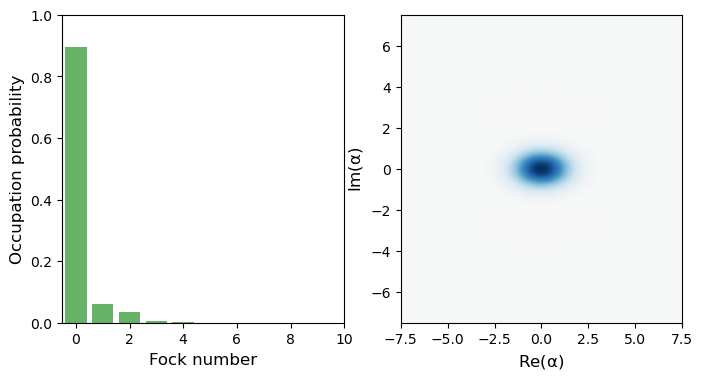

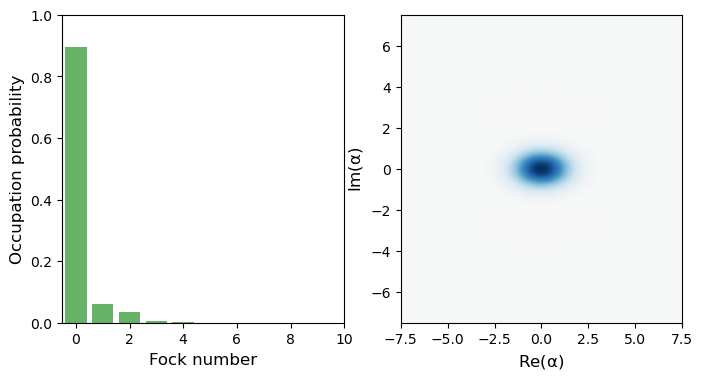

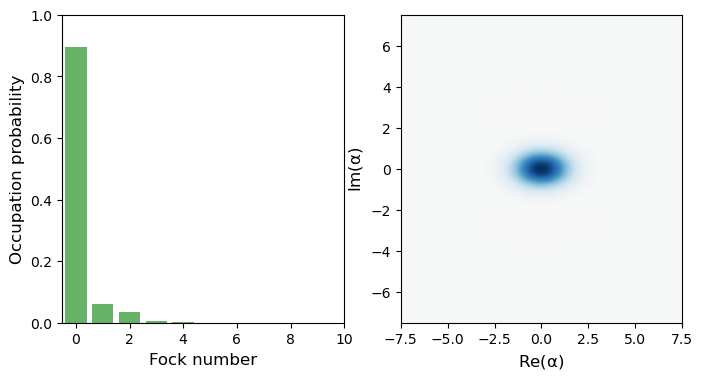

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_fock_distribution(rhoss2.ptrace(0), fig=fig, ax=axes[0])
plot_wigner(rhoss2.ptrace(0), fig=fig, ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_fock_distribution(rhoss4.ptrace(0), fig=fig, ax=axes[0])
plot_wigner(rhoss4.ptrace(0), fig=fig, ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_fock_distribution(rhoss8.ptrace(0), fig=fig, ax=axes[0])
plot_wigner(rhoss8.ptrace(0), fig=fig, ax=axes[1]);

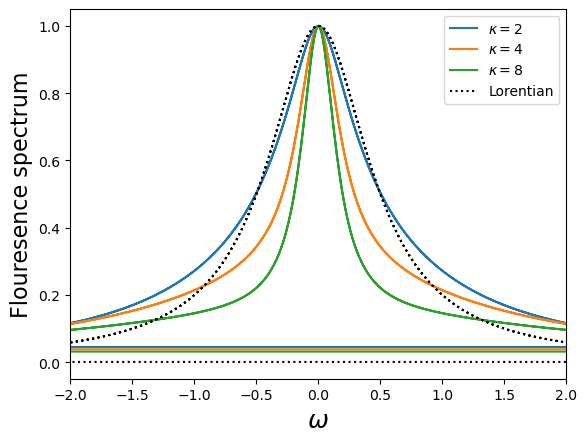

In [6]:
fig, ax = plt.subplots()
ax.plot(w2, S2 / S2.max(), label=r"$\kappa = 2$")
ax.plot(w4, S4 / S4.max(), label=r"$\kappa = 4$")
ax.plot(w8, S8 / S8.max(), label=r"$\kappa = 8$")
ax.plot(w8, 0.25 / ((0.5 * gamma) ** 2 + w8**2), "k:", label=r"Lorentian")
ax.legend()
ax.set_ylabel(r"Flouresence spectrum", fontsize=16)
ax.set_xlabel(r"$\omega$", fontsize=18)
ax.set_xlim(-2, 2);

Fig. 12.4 in Quantum Noise.

## Two-level atom driven by antibunched light: coherent excitation of the source atom

The master equation given in Sec. 12.3.1 in Quantum Noise, for two coupled atoms where the first atom (source atom) is irradiated with coherent light, and the second atom is irradiated by the antibunched light emitted from the source atom, is:

$$
\dot\rho = -i[H, \rho] + \gamma_1\mathcal{D}[\sigma^-_{1}]\rho + \gamma_2\mathcal{D}[\sigma^-_{2}]\rho
-\sqrt{(1-\epsilon_1)(1-\epsilon_2)\gamma_1\gamma_2}
([\sigma_2^+, \sigma_1^-\rho] + [\rho\sigma_1^+, \sigma_2^-])
$$

where

$$
H = -i\sqrt{\epsilon_1\gamma_1}(E\sigma_1^+ - E^*\sigma_1^-)
$$

In [7]:
e1 = 0.5
e2 = 0.5

gamma1 = 2
gamma2 = 2

E = 2 / np.sqrt(e1 * gamma1)

In [8]:
sm1 = tensor(destroy(2), identity(2))
sp1 = sm1.dag()
sm2 = tensor(identity(2), destroy(2))
sp2 = sm2.dag()

In [9]:
H = -1j * np.sqrt(e1 * gamma1) * (E * sp1 - np.conjugate(E) * sm1)

In [10]:
L0 = liouvillian(H, [np.sqrt(gamma1) * sm1, np.sqrt(gamma2) * sm2])

In [11]:
L1 = -np.sqrt((1 - e1) * (1 - e2) * gamma1 * gamma2) * (
    spre(sp2 * sm1) - spre(sm1) * spost(sp2) +
    spost(sp1 * sm2) - spre(sm2) * spost(sp1)
)

In [12]:
L = L0 + L1

In [13]:
# steady state
rhoss = steadystate(L)

In [14]:
# correlation function and spectrum
taulist = np.linspace(0, 4, 250)

In [15]:
G2_11 = correlation_3op_1t(L, rhoss, taulist, [], sp1, sp1 * sm1, sm1)
g2_11 = G2_11 / (expect(sp1 * sm1, rhoss) * expect(sp1 * sm1, rhoss))

In [16]:
G2_22 = correlation_3op_1t(L, rhoss, taulist, [], sp2, sp2 * sm2, sm2)
g2_22 = G2_22 / (expect(sp2 * sm2, rhoss) * expect(sp2 * sm2, rhoss))

In [17]:
G2_12 = correlation_3op_1t(L, rhoss, taulist, [], sp2, sp1 * sm1, sm2)
g2_12 = G2_12 / (expect(sp1 * sm1, rhoss) * expect(sp2 * sm2, rhoss))

In [18]:
G2_21 = correlation_3op_1t(L, rhoss, taulist, [], sp1, sp2 * sm2, sm1)
g2_21 = G2_21 / (expect(sp2 * sm2, rhoss) * expect(sp1 * sm1, rhoss))

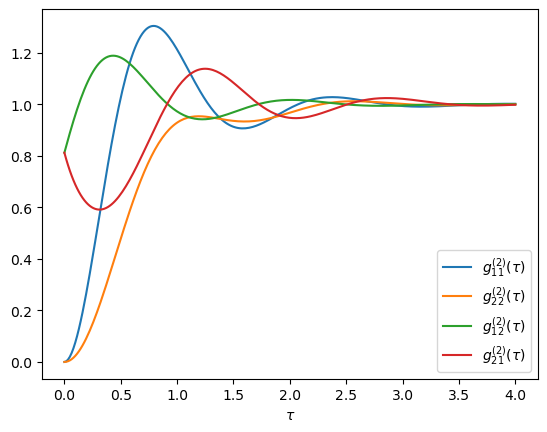

In [19]:
fig, ax = plt.subplots()

ax.plot(taulist, np.real(g2_11), label=r"$g^{(2)}_{11}(\tau)$")
ax.plot(taulist, np.real(g2_22), label=r"$g^{(2)}_{22}(\tau)$")
ax.plot(taulist, np.real(g2_12), label=r"$g^{(2)}_{12}(\tau)$")
ax.plot(taulist, np.real(g2_21), label=r"$g^{(2)}_{21}(\tau)$")

ax.legend(loc=4)
ax.set_xlabel(r"$\tau$");

Fig. 12.6 in Quantum Noise.

## Two-level atom driven by antibunched light: incoherent excitation of the source atom

When the source atom is irradiated with incoherent light, the master equation becomes (Sec. 12.3.2 in Quantum Noise)

$$
\dot\rho =
\gamma_1\mathcal{D}[\sigma^-_{1}]\rho +
\gamma_2\mathcal{D}[\sigma^-_{2}]\rho +
\kappa(\bar{N} + 1)\mathcal{D}[a]\rho +
\kappa\bar{N}\mathcal{D}[a^\dagger]\rho
-\sqrt{2\kappa\eta_1\gamma_1} ([\sigma_1^+, a\rho] + [\rho a^\dagger, \sigma_1^-])
-\sqrt{\eta_2\gamma1\gamma_2} ([\sigma_2^+, \sigma_1^-\rho] + [\rho\sigma_1^+, \sigma_2^-])
$$


In [20]:
N = 10

e1 = 0.5
e2 = 0.5
ek = 0.5

n_th = 1
kappa = 0.1
gamma1 = 1
gamma2 = 1

E = 0.025

taulist = np.linspace(0, 5, 250)

In [21]:
a = tensor(destroy(N), identity(2), identity(2))
sm1 = tensor(identity(N), destroy(2), identity(2))
sp1 = sm1.dag()
sm2 = tensor(identity(N), identity(2), destroy(2))
sp2 = sm2.dag()

In [22]:
def solve(ek, e1, e2, gamma1, gamma2, kappa, n_th, E):

    eta1 = (1 - ek) * e1
    eta2 = (1 - e1) * (1 - e2)

    H = 1j * E * (a - a.dag())

    L0 = liouvillian(
        H,
        [
            np.sqrt(kappa * (1 + n_th)) * a,
            np.sqrt(kappa * n_th) * a.dag(),
            np.sqrt(gamma1) * sm1,
            np.sqrt(gamma2) * sm2,
        ],
    )

    L1 = -np.sqrt(2 * kappa * eta1 * gamma1) * (
        spre(sp1 * a)
        - spre(a) * spost(sp1)
        + spost(a.dag() * sm1)
        - spre(sm1) * spost(a.dag())
    ) + -np.sqrt(eta2 * gamma1 * gamma2) * (
        spre(sp2 * sm1)
        - spre(sm1) * spost(sp2)
        + spost(sp1 * sm2)
        - spre(sm2) * spost(sp1)
    )

    L = L0 + L1

    rhoss = steadystate(L)

    G2_11 = correlation_3op_1t(L, rhoss, taulist, [], sp1, sp1 * sm1, sm1)
    g2_11 = G2_11 / (expect(sp1 * sm1, rhoss) * expect(sp1 * sm1, rhoss))

    G2_22 = correlation_3op_1t(L, rhoss, taulist, [], sp2, sp2 * sm2, sm2)
    g2_22 = G2_22 / (expect(sp2 * sm2, rhoss) * expect(sp2 * sm2, rhoss))

    G2_12 = correlation_3op_1t(L, rhoss, taulist, [], sp2, sp1 * sm1, sm2)
    g2_12 = G2_12 / (expect(sp1 * sm1, rhoss) * expect(sp2 * sm2, rhoss))

    G2_21 = correlation_3op_1t(L, rhoss, taulist, [], sp1, sp2 * sm2, sm1)
    g2_21 = G2_21 / (expect(sp2 * sm2, rhoss) * expect(sp1 * sm1, rhoss))

    return rhoss, g2_11, g2_12, g2_21, g2_22

In [23]:
# thermal
rhoss_t, g2_11_t, g2_12_t, g2_21_t, g2_22_t = solve(
    ek, e1, e2, gamma1, gamma2, kappa, n_th, 0.0
)

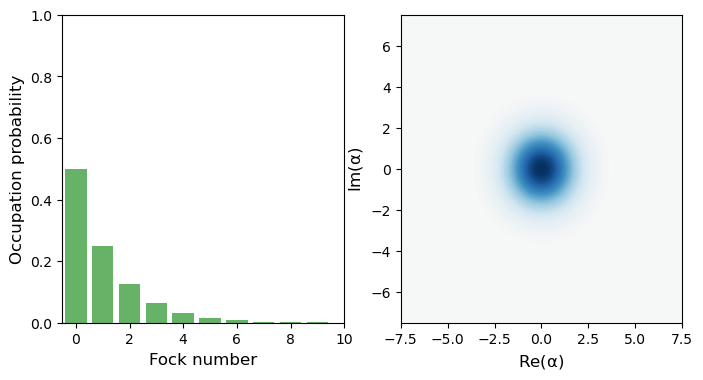

In [24]:
# visualize the cavity state
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_fock_distribution(rhoss_t.ptrace(0), fig=fig, ax=axes[0])
plot_wigner(rhoss_t.ptrace(0), fig=fig, ax=axes[1]);

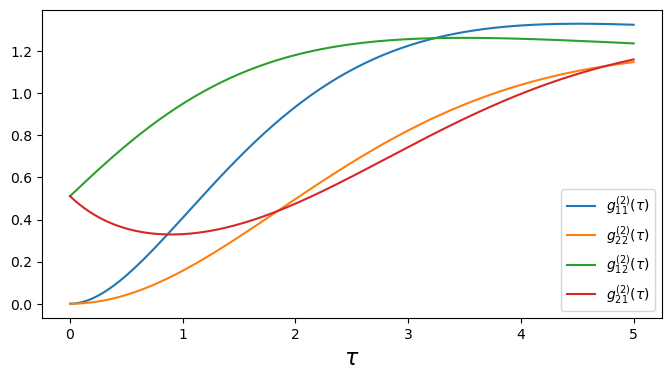

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(taulist, np.real(g2_11_t), label=r"$g^{(2)}_{11}(\tau)$")
ax.plot(taulist, np.real(g2_22_t), label=r"$g^{(2)}_{22}(\tau)$")
ax.plot(taulist, np.real(g2_12_t), label=r"$g^{(2)}_{12}(\tau)$")
ax.plot(taulist, np.real(g2_21_t), label=r"$g^{(2)}_{21}(\tau)$")

ax.legend(loc=4)
ax.set_xlabel(r"$\tau$", fontsize=16);

Similar to Fig. 12.8 in Quantum Noise, although not exactly because of different parameters.

## Versions

In [26]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
